# Setup

The [CEng501 Project](https://drive.google.com/drive/folders/1J7y9HjEyx_T2PJ4kOdvuTIJ5lZF3gHrX?usp=sharing) folder has been shared. Create a shortcut to it under your Google Drive Colab Notebooks folder. This notebook can mount that folder and load data from there or access other notebooks or Python modules. When the notebook runs the following cell to mount your Google Drive, it will ask for authorization. Just follow the directions.

In [26]:
from google.colab import drive
drive.mount('/content/gdrive')
import os, sys
os.chdir('/content/gdrive/MyDrive/Colab Notebooks/CEng501 Project/')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [27]:
# Copy MNIST data to the shared memory for faster access.
# If this fails, no problem. The data module will download it again.
!cp -r MNIST/MNIST /dev/shm/

In [28]:
%%capture
!pip install -qqq pytorch-lightning
!pip install -qqq foolbox
# install and import the torchinfo library
!pip install -qqq torchinfo
from torchinfo import summary
# Install torchdiffeq
!pip install -qqq git+https://github.com/rtqichen/torchdiffeq
#!pip install -qqq cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8-cp37-cp37m-linux_x86_64.whl

In [29]:
# Choose which models to train. (Trained models are afterward loaded from disk.)
models_to_train = {'CNN', 'CNN_aug', 'CNN_FDn', 'CNN_IRd',
                   'ODE_Net', 'ODE_Net_aug',
                   'TisODE_aug', 'TisODE_FDn', 'TisODE_IRd'}
seeds = [501, 56, 23]
std_list = [50, 75, 100]

In [30]:
# Shared utility functions are in module utils.py
# Use the autoreload extension to reload these functions if they are modified
# https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html
#
# utils.py can be edited on Google Drive using commanditor
%load_ext autoreload
%autoreload 1
sys.path.append('/content/gdrive/MyDrive/Colab Notebooks/CEng501 Project/')
%aimport utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
from functools import partial
import numpy as np
import torch
import foolbox
from torch import nn
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as T
torch.backends.cudnn.deterministic = True

print('Pytorch version:', torch.__version__)
print('Using {} device'.format(utils.device))


Pytorch version: 1.9.0+cu102
Using cuda device


# Define dataloader


The Pytorch Lightning DataModule class is used to organize the dataset loading code. A custom base class for the project is used that incorporates the addition of Gaussian noise if desired. See utils.py for details.

In [32]:
class MNISTDataModule(utils.BasePLDataModule):
  def __init__(self, data_dir: str = '/dev/shm/', batch_size: int = 128,
               augment_training=None,
               test_gaussian_noise=None):
    super().__init__(data_dir, batch_size, augment_training, test_gaussian_noise)
    self.name = 'MNIST'
    
    self.get_train = partial(MNIST, self.data_dir, train=True)
    self.get_test = partial(MNIST, self.data_dir, train=False)

    self.mean = [0.1307]
    self.stddev = [0.3081]
    
    self.normalize = T.Normalize(self.mean, self.stddev)

    self.dims = (1, 28, 28)
    self.train_val_split = [55000, 5000]

The following cell is only used to calculate the mean and standard deviation for normalizing the dataset. It should give the same values used in the previous cell.

In [33]:
# The mean and standard deviation of the dataset is needed for normalization
training_data = MNIST('/dev/shm/', train=True, download=True, transform=T.ToTensor())

# Load the whole dataset in one batch to calculate the mean and std
loader = DataLoader(training_data, batch_size=len(training_data))
data = next(iter(loader))
print('Max:', data[0].max())
print('Min:', data[0].min())
std, mean = torch.std_mean(data[0], [0, 2, 3])
print('Mean:', mean)
print('Std:', std)

Max: tensor(1.)
Min: tensor(0.)
Mean: tensor([0.1307])
Std: tensor([0.3081])


In [34]:
vanilla_dm = MNISTDataModule()
vanilla_dm.prepare_data()
vanilla_dm.setup()

print('Data shape:', vanilla_dm.train_set[0][0].shape)
print('Max:', vanilla_dm.train_set[0][0].max())
print('Min:', vanilla_dm.train_set[0][0].min())

Data shape: torch.Size([1, 28, 28])
Max: tensor(2.8215)
Min: tensor(-0.4242)


In [35]:
augmented_dm = MNISTDataModule(augment_training=std_list)
augmented_dm.prepare_data()
augmented_dm.setup()

print('Data shape:', augmented_dm.train_set[0][0].shape)
print('Max:', augmented_dm.train_set[0][0].max())
print('Min:', augmented_dm.train_set[0][0].min())

Data shape: torch.Size([1, 28, 28])
Max: tensor(2.8215)
Min: tensor(-0.4242)


torch.Size([128, 1, 28, 28])


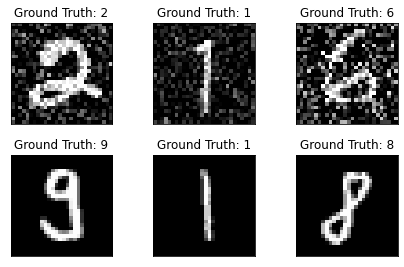

In [36]:
#lets view a few training images from the augmented dataset
examples_test = enumerate(augmented_dm.train_dataloader())
batch_idx, (gauss_test_data_1, gauss_test_targets) = next(examples_test)
print(gauss_test_data_1.shape)
fig = plt.figure()
for i in range(6):
  plt.subplot(2, 3, i+1)
  plt.tight_layout()
  plt.imshow(gauss_test_data_1[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(gauss_test_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig.show()

torch.Size([128, 1, 28, 28])


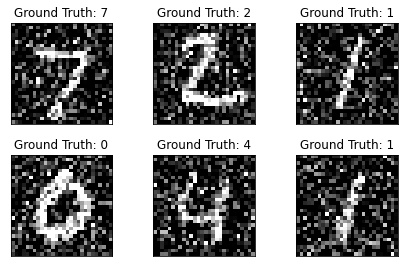

In [37]:
#lets view a few images with noise added
test_dm = MNISTDataModule(test_gaussian_noise=std_list[-1])
test_dm.setup()
examples_test = enumerate(test_dm.test_dataloader())
batch_idx, (gauss_test_data_1, gauss_test_targets) = next(examples_test)
print(gauss_test_data_1.shape)
fig = plt.figure()
for i in range(6):
  plt.subplot(2, 3, i+1)
  plt.tight_layout()
  plt.imshow(gauss_test_data_1[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(gauss_test_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig.show()

# Define models

## CNN model class

In [38]:
# Set num_groups to 32 to match what is used in odenet example
# https://github.com/rtqichen/torchdiffeq/blob/master/examples/odenet_mnist.py
def norm(dim):
    return nn.GroupNorm(min(32, dim), dim)

# Input randomization output size not specified in the paper
IRd_output_size = 36


class CNN_Net(utils.BasePLSystem):
  def __init__(self, robustness=None, **kwargs):
    super().__init__(robustness=robustness, **kwargs)
    self.robustness = robustness

    # Optional input randomization layer
    if robustness == 'IRd':
      layers = [utils.InputRandomization(output_size=IRd_output_size)]
    else:
      layers = []

    layers.extend([
      # FE layers
      nn.Conv2d(1, 64, 3, 1),
      norm(64),
      nn.ReLU(),
      nn.Conv2d(64, 64, 4, 2),
      norm(64),
      nn.ReLU(),
      # RM layers
      nn.Conv2d(64, 64, 3, 1),
      norm(64),
      nn.ReLU(),
      nn.Conv2d(64, 64, 3, 1),
      norm(64),
      nn.ReLU()])
    
    # Optional feature denoising layer
    if robustness == 'FDn':
      layers.append(utils.FeatureDenoising(64))

    # FCC layer
    layers.extend([  
      nn.AdaptiveAvgPool2d((1, 1)),
      nn.Flatten(),
      nn.Linear(64, 10)])

    self.model = nn.Sequential(*layers)
    
  def forward(self, x):
    return self.model(x)

model = CNN_Net().to('cpu')
summary(model, input_size=[vanilla_dm.batch_size, *vanilla_dm.dims])

Layer (type:depth-idx)                   Output Shape              Param #
CNN_Net                                  --                        --
├─Sequential: 1-1                        [128, 10]                 --
│    └─Conv2d: 2-1                       [128, 64, 26, 26]         640
│    └─GroupNorm: 2-2                    [128, 64, 26, 26]         128
│    └─ReLU: 2-3                         [128, 64, 26, 26]         --
│    └─Conv2d: 2-4                       [128, 64, 12, 12]         65,600
│    └─GroupNorm: 2-5                    [128, 64, 12, 12]         128
│    └─ReLU: 2-6                         [128, 64, 12, 12]         --
│    └─Conv2d: 2-7                       [128, 64, 10, 10]         36,928
│    └─GroupNorm: 2-8                    [128, 64, 10, 10]         128
│    └─ReLU: 2-9                         [128, 64, 10, 10]         --
│    └─Conv2d: 2-10                      [128, 64, 8, 8]           36,928
│    └─GroupNorm: 2-11                   [128, 64, 8, 8]           12

Compare to paper saying that the ODENET and CNN model have a total of about **140k** parameters.

In [39]:
# Since model naming is done based on the class name, subclass to get
# the FDn version.
class CNN_Net_FDn(CNN_Net):
  def __init__(self, **kwargs):
    kwargs['robustness'] = 'FDn'
    super().__init__(**kwargs)

model = CNN_Net_FDn().to('cpu')
summary(model, input_size=[vanilla_dm.batch_size, *vanilla_dm.dims])

Layer (type:depth-idx)                   Output Shape              Param #
CNN_Net_FDn                              --                        --
├─Sequential: 1-1                        [128, 10]                 --
│    └─Conv2d: 2-1                       [128, 64, 26, 26]         640
│    └─GroupNorm: 2-2                    [128, 64, 26, 26]         128
│    └─ReLU: 2-3                         [128, 64, 26, 26]         --
│    └─Conv2d: 2-4                       [128, 64, 12, 12]         65,600
│    └─GroupNorm: 2-5                    [128, 64, 12, 12]         128
│    └─ReLU: 2-6                         [128, 64, 12, 12]         --
│    └─Conv2d: 2-7                       [128, 64, 10, 10]         36,928
│    └─GroupNorm: 2-8                    [128, 64, 10, 10]         128
│    └─ReLU: 2-9                         [128, 64, 10, 10]         --
│    └─Conv2d: 2-10                      [128, 64, 8, 8]           36,928
│    └─GroupNorm: 2-11                   [128, 64, 8, 8]           12

In [40]:
class CNN_Net_IRd(CNN_Net):
  def __init__(self, **kwargs):
    kwargs['robustness'] = 'IRd'
    super().__init__(**kwargs)

model = CNN_Net_IRd().to('cpu')
summary(model, input_size=[vanilla_dm.batch_size, *vanilla_dm.dims])

Layer (type:depth-idx)                   Output Shape              Param #
CNN_Net_IRd                              --                        --
├─Sequential: 1-1                        [128, 10]                 --
│    └─InputRandomization: 2-1           [128, 1, 36, 36]          --
│    └─Conv2d: 2-2                       [128, 64, 34, 34]         640
│    └─GroupNorm: 2-3                    [128, 64, 34, 34]         128
│    └─ReLU: 2-4                         [128, 64, 34, 34]         --
│    └─Conv2d: 2-5                       [128, 64, 16, 16]         65,600
│    └─GroupNorm: 2-6                    [128, 64, 16, 16]         128
│    └─ReLU: 2-7                         [128, 64, 16, 16]         --
│    └─Conv2d: 2-8                       [128, 64, 14, 14]         36,928
│    └─GroupNorm: 2-9                    [128, 64, 14, 14]         128
│    └─ReLU: 2-10                        [128, 64, 14, 14]         --
│    └─Conv2d: 2-11                      [128, 64, 12, 12]         36,928

## Neural ODE Models

In [41]:
class ODEfunc(nn.Module):

    def __init__(self, dim):
        super(ODEfunc, self).__init__()
        self.relu = nn.ReLU()
        self.conv1 = utils.ConcatConv2d(dim, dim, 3, 1, 1)
        self.norm1 = norm(64)
        self.conv2 = utils.ConcatConv2d(dim, dim, 3, 1, 1)
        self.norm2 = norm(64)
        self.nfe = 0

    def forward(self, t, x):
        self.nfe += 1
        out = self.conv1(t, x)
        out = self.norm1(out)
        out = self.relu(out)
        out = self.conv2(t, out)
        out = self.norm2(out)
        out = self.relu(out)
        return out

In [42]:
class ODE_Net(utils.BasePLSystem):
  def __init__(self, robustness=None, **kwargs):
    super().__init__(robustness=robustness, **kwargs)
    self.robustness = robustness

    # Optional input randomization layer
    if robustness == 'IRd':
      layers = [utils.InputRandomization(output_size=IRd_output_size)]
    else:
      layers = []

    layers.extend([
      # FE layers
      nn.Conv2d(1, 64, 3, 1),
      norm(64),
      nn.ReLU(),
      nn.Conv2d(64, 64, 4, 2),
      norm(64),
      nn.ReLU(),
      # RM layers
      utils.ODEBlock(ODEfunc(64))
    ])
    
    # Optional feature denoising layer
    if robustness == 'FDn':
      layers.append(utils.FeatureDenoising(64))

    # FCC layer
    layers.extend([  
      nn.AdaptiveAvgPool2d((1, 1)),
      nn.Flatten(),
      nn.Linear(64, 10)])
    
    self.model = nn.Sequential(*layers)
    
  def forward(self, x):
    return self.model(x)

model = ODE_Net().to('cpu')
summary(model, input_size=[vanilla_dm.batch_size, *vanilla_dm.dims])

Layer (type:depth-idx)                   Output Shape              Param #
ODE_Net                                  --                        --
├─Sequential: 1-1                        [128, 10]                 --
│    └─Conv2d: 2-1                       [128, 64, 26, 26]         640
│    └─GroupNorm: 2-2                    [128, 64, 26, 26]         128
│    └─ReLU: 2-3                         [128, 64, 26, 26]         --
│    └─Conv2d: 2-4                       [128, 64, 12, 12]         65,600
│    └─GroupNorm: 2-5                    [128, 64, 12, 12]         128
│    └─ReLU: 2-6                         [128, 64, 12, 12]         --
│    └─ODEBlock: 2-7                     [128, 64, 12, 12]         --
│    │    └─ODEfunc: 3-1                 [128, 64, 12, 12]         75,264
│    │    └─ODEfunc: 3-2                 [128, 64, 12, 12]         (recursive)
│    │    └─ODEfunc: 3-3                 [128, 64, 12, 12]         (recursive)
│    │    └─ODEfunc: 3-4                 [128, 64, 12, 1

## TisODE Models

In [43]:
class TisODEfunc(nn.Module):

    def __init__(self, dim):
        super().__init__()
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(dim, dim, 3, 1, 1)
        self.norm1 = norm(dim)
        self.conv2 = nn.Conv2d(dim, dim, 3, 1, 1)
        self.norm2 = norm(dim)
        self.nfe = 0

    def forward(self, t, x):
        # t is passed as an argument but not used in evaluation since the
        # function is time invariant.
        self.nfe += 1
        out = self.conv1(x)
        out = self.norm1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.norm2(out)
        out = self.relu(out)
        return out

In [44]:
class TisODE_Net(utils.TisODEBase):
  def __init__(self, robustness=None, step_size=0.1, L_ss_weight=0.01,
               start_regularization=5, **kwargs):
    super().__init__(robustness=robustness, step_size=step_size,
                     L_ss_weight=L_ss_weight,
                     start_regularization=start_regularization, **kwargs)

    # Optional input randomization layer
    if robustness == 'IRd':
      layers1 = [utils.InputRandomization(output_size=IRd_output_size)]
    else:
      layers1 = []

    # FE layers
    layers1.extend([
      nn.Conv2d(1, 64, 3, 1),
      norm(64),
      nn.ReLU(),
      nn.Conv2d(64, 64, 4, 2),
      norm(64),
      nn.ReLU()
    ])
    self.model1 = nn.Sequential(*layers1)

    # RM layer
    self.odeblock = utils.ODEBlock(TisODEfunc(64))

    # Optional feature denoising layer
    layers2 = [utils.FeatureDenoising(64)] if robustness == 'FDn' else []

    # FCC layer
    layers2.extend([
      nn.AdaptiveAvgPool2d((1, 1)),
      nn.Flatten(),
      nn.Linear(64, 10)])
    
    self.model2 = nn.Sequential(*layers2)

model = TisODE_Net().to('cpu')
summary(model, input_size=[vanilla_dm.batch_size, *vanilla_dm.dims])

Layer (type:depth-idx)                   Output Shape              Param #
TisODE_Net                               --                        --
├─Sequential: 1-1                        [128, 64, 12, 12]         --
│    └─Conv2d: 2-1                       [128, 64, 26, 26]         640
│    └─GroupNorm: 2-2                    [128, 64, 26, 26]         128
│    └─ReLU: 2-3                         [128, 64, 26, 26]         --
│    └─Conv2d: 2-4                       [128, 64, 12, 12]         65,600
│    └─GroupNorm: 2-5                    [128, 64, 12, 12]         128
│    └─ReLU: 2-6                         [128, 64, 12, 12]         --
├─ODEBlock: 1-2                          [128, 64, 12, 12]         --
│    └─TisODEfunc: 2-7                   [128, 64, 12, 12]         --
│    │    └─Conv2d: 3-1                  [128, 64, 12, 12]         36,928
│    │    └─GroupNorm: 3-2               [128, 64, 12, 12]         128
│    │    └─ReLU: 3-3                    [128, 64, 12, 12]         --
│  

In [45]:
class TisODE_Net_FDn(TisODE_Net):
  def __init__(self, **kwargs):
    kwargs['robustness'] = 'FDn'
    super().__init__(**kwargs)

model = TisODE_Net_FDn().to('cpu')
summary(model, input_size=[vanilla_dm.batch_size, *vanilla_dm.dims])

Layer (type:depth-idx)                   Output Shape              Param #
TisODE_Net_FDn                           --                        --
├─Sequential: 1-1                        [128, 64, 12, 12]         --
│    └─Conv2d: 2-1                       [128, 64, 26, 26]         640
│    └─GroupNorm: 2-2                    [128, 64, 26, 26]         128
│    └─ReLU: 2-3                         [128, 64, 26, 26]         --
│    └─Conv2d: 2-4                       [128, 64, 12, 12]         65,600
│    └─GroupNorm: 2-5                    [128, 64, 12, 12]         128
│    └─ReLU: 2-6                         [128, 64, 12, 12]         --
├─ODEBlock: 1-2                          [128, 64, 12, 12]         --
│    └─TisODEfunc: 2-7                   [128, 64, 12, 12]         --
│    │    └─Conv2d: 3-1                  [128, 64, 12, 12]         36,928
│    │    └─GroupNorm: 3-2               [128, 64, 12, 12]         128
│    │    └─ReLU: 3-3                    [128, 64, 12, 12]         --
│  

In [46]:
class TisODE_Net_IRd(TisODE_Net):
  def __init__(self, **kwargs):
    kwargs['robustness'] = 'IRd'
    super().__init__(**kwargs)

model = TisODE_Net_IRd().to('cpu')
summary(model, input_size=[vanilla_dm.batch_size, *vanilla_dm.dims])

Layer (type:depth-idx)                   Output Shape              Param #
TisODE_Net_IRd                           --                        --
├─Sequential: 1-1                        [128, 64, 16, 16]         --
│    └─InputRandomization: 2-1           [128, 1, 36, 36]          --
│    └─Conv2d: 2-2                       [128, 64, 34, 34]         640
│    └─GroupNorm: 2-3                    [128, 64, 34, 34]         128
│    └─ReLU: 2-4                         [128, 64, 34, 34]         --
│    └─Conv2d: 2-5                       [128, 64, 16, 16]         65,600
│    └─GroupNorm: 2-6                    [128, 64, 16, 16]         128
│    └─ReLU: 2-7                         [128, 64, 16, 16]         --
├─ODEBlock: 1-2                          [128, 64, 16, 16]         --
│    └─TisODEfunc: 2-8                   [128, 64, 16, 16]         --
│    │    └─Conv2d: 3-1                  [128, 64, 16, 16]         36,928
│    │    └─GroupNorm: 3-2               [128, 64, 16, 16]         128
│  

# Train Models

In [61]:
#Hyperparameters
hp = {'optimizer': 'Adam',
  'weight_decay': 0.0005,
  'epochs': 250,  # But it can stop early if not improving
  'learning_rate': 0.015,
  'plateau_min_delta': 0.001,
  'plateau_patience': 2,
  'plateau_cooldown': 0,
  'early_stopping_min_delta': 0.002,
  'early_stopping_patience': 5}

## Train CNN models

In [ ]:
if 'CNN' in models_to_train:
  systems, trainers = utils.train_and_save(CNN_Net, vanilla_dm, seeds, **hp)

In [ ]:
if 'CNN_aug' in models_to_train:
  systems, trainers = utils.train_and_save(CNN_Net, augmented_dm, seeds, **hp)

In [ ]:
if 'CNN_FDn' in models_to_train:
  systems, trainers = utils.train_and_save(CNN_Net_FDn, augmented_dm, seeds, **hp)

In [ ]:
if 'CNN_IRd' in models_to_train:
  systems, trainers = utils.train_and_save(CNN_Net_IRd, augmented_dm, seeds, **hp)

## Train Neural ODE models

In [ ]:
if 'ODE_Net' in models_to_train:
  systems, trainers = utils.train_and_save(ODE_Net, vanilla_dm, seeds, **hp)

In [ ]:
if 'ODE_Net_aug' in models_to_train:
  systems, trainers = utils.train_and_save(ODE_Net, augmented_dm, seeds, **hp)

## Train TisODE models

In [54]:
#Hyperparameters
hp = {'optimizer': 'Adam',
  'weight_decay': 0.0005,
  'epochs': 50,
  'learning_rate': 0.015,
  'plateau_min_delta': 0.001,
  'plateau_patience': 2,
  'plateau_cooldown': 0,
  'early_stopping_min_delta': 0.002,
  'early_stopping_patience': 10,
  'start_regularization': 5}

In [ ]:
if 'TisODE_aug' in models_to_train:
  systems, trainers = utils.train_and_save(TisODE_Net, augmented_dm, seeds, **hp)

In [ ]:
if 'TisODE_FDn' in models_to_train:
  systems, trainers = utils.train_and_save(TisODE_Net_FDn, augmented_dm, seeds, **hp)

In [ ]:
if 'TisODE_IRd' in models_to_train:
  systems, trainers = utils.train_and_save(TisODE_Net_IRd, augmented_dm, seeds, **hp)

# Results

## Models trained on non-perturbed images

Compare to Table 1 in Section 3.2 of the paper.

In [64]:
# Verify model against unmodified dataset test data
models = utils.load_models(vanilla_dm, CNN_Net, seeds)
results = utils.test_models(models, vanilla_dm, {0: vanilla_dm})

CNN_Net gaussian=0: accuracy=99.2 ± 0.1


In [65]:
gauss_test_sets1 = {std: MNISTDataModule(test_gaussian_noise=std) for std in std_list}
for gauss_strength, dm in gauss_test_sets1.items():
  dm.setup()

In [66]:
models = utils.load_models(vanilla_dm, CNN_Net, seeds)
results = utils.test_models(models, vanilla_dm, gauss_test_sets1,
                            [0.15, 0.3, 0.5])


CNN_Net gaussian=50: accuracy=98.5 ± 0.0
CNN_Net gaussian=75: accuracy=94.5 ± 1.1
CNN_Net gaussian=100: accuracy=77.8 ± 4.2
CNN_Net fgsm=0.15: accuracy=67.7 ± 3.7
CNN_Net fgsm=0.3: accuracy=27.7 ± 3.6
CNN_Net fgsm=0.5: accuracy=9.9 ± 2.0


In [67]:
models = utils.load_models(vanilla_dm, ODE_Net, seeds)
results = utils.test_models(models, vanilla_dm, gauss_test_sets1,
                            [0.15, 0.3, 0.5])

ODE_Net gaussian=50: accuracy=98.9 ± 0.1
ODE_Net gaussian=75: accuracy=96.5 ± 0.8
ODE_Net gaussian=100: accuracy=87.4 ± 4.8
ODE_Net fgsm=0.15: accuracy=84.6 ± 1.5
ODE_Net fgsm=0.3: accuracy=49.6 ± 3.0
ODE_Net fgsm=0.5: accuracy=18.5 ± 1.2


## Models trained on original images together with Gaussian perturbations

Compare to Table 2 in Section 3.3 of the paper and Table 3 in Section 4.2 of the paper.

In [68]:
gauss_test_sets2 = {std: MNISTDataModule(test_gaussian_noise=std) for std in [100]}
for gauss_strength, dm in gauss_test_sets2.items():
  dm.setup()

In [69]:
models = utils.load_models(augmented_dm, CNN_Net, seeds)
results = utils.test_models(models, vanilla_dm, gauss_test_sets2,
                            [0.3, 0.5],
                            [0.2, 0.3])

CNN_Net_aug gaussian=100: accuracy=97.9 ± 0.4
CNN_Net_aug fgsm=0.3: accuracy=52.4 ± 2.7
CNN_Net_aug fgsm=0.5: accuracy=16.5 ± 2.2
CNN_Net_aug pdg=0.2: accuracy=43.3 ± 1.1
CNN_Net_aug pdg=0.3: accuracy=0.6 ± 0.3


In [70]:
models = utils.load_models(augmented_dm, ODE_Net, seeds)
results = utils.test_models(models, vanilla_dm, gauss_test_sets2,
                            [0.3, 0.5],
                            [0.2, 0.3])

ODE_Net_aug gaussian=100: accuracy=98.4 ± 0.1
ODE_Net_aug fgsm=0.3: accuracy=69.3 ± 2.4
ODE_Net_aug fgsm=0.5: accuracy=28.4 ± 1.2
ODE_Net_aug pdg=0.2: accuracy=72.8 ± 0.5
ODE_Net_aug pdg=0.3: accuracy=20.2 ± 0.6


In [58]:
models = utils.load_models(augmented_dm, TisODE_Net, seeds)
results = utils.test_models(models, vanilla_dm, gauss_test_sets2,
                            [0.3, 0.5],
                            [0.2, 0.3])

/usr/local/lib/python3.7/dist-packages/torchdiffeq/_impl/misc.py:296: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")
TisODE_Net_aug gaussian=100: accuracy=77.4 ± 19.9
TisODE_Net_aug fgsm=0.3: accuracy=35.5 ± 24.8
TisODE_Net_aug fgsm=0.5: accuracy=14.7 ± 7.1
TisODE_Net_aug pdg=0.2: accuracy=36.2 ± 35.2
TisODE_Net_aug pdg=0.3: accuracy=7.3 ± 9.6


## Models with added layers to improve robustness

Compare to Table 4 in Section 4.3 of the paper.

In [71]:
# This is a repeat of above
models = utils.load_models(augmented_dm, CNN_Net, seeds)
results = utils.test_models(models, vanilla_dm, gauss_test_sets2,
                            [0.3, 0.5],
                            [0.2, 0.3])

CNN_Net_aug gaussian=100: accuracy=97.9 ± 0.4
CNN_Net_aug fgsm=0.3: accuracy=52.4 ± 2.7
CNN_Net_aug fgsm=0.5: accuracy=16.5 ± 2.2
CNN_Net_aug pdg=0.2: accuracy=43.3 ± 1.1
CNN_Net_aug pdg=0.3: accuracy=0.6 ± 0.3


In [72]:
models = utils.load_models(augmented_dm, CNN_Net_FDn, seeds)
results = utils.test_models(models, vanilla_dm, gauss_test_sets2,
                            [0.3, 0.5],
                            [0.2, 0.3])

CNN_Net_FDn_aug gaussian=100: accuracy=98.1 ± 0.1
CNN_Net_FDn_aug fgsm=0.3: accuracy=60.6 ± 5.5
CNN_Net_FDn_aug fgsm=0.5: accuracy=23.8 ± 4.7
CNN_Net_FDn_aug pdg=0.2: accuracy=49.0 ± 7.4
CNN_Net_FDn_aug pdg=0.3: accuracy=4.1 ± 1.4


In [59]:
models = utils.load_models(augmented_dm, TisODE_Net_FDn, seeds)
results = utils.test_models(models, vanilla_dm, gauss_test_sets2,
                            [0.3, 0.5],
                            [0.2, 0.3])

/usr/local/lib/python3.7/dist-packages/torchdiffeq/_impl/misc.py:296: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")
TisODE_Net_FDn_aug gaussian=100: accuracy=87.0 ± 6.0
TisODE_Net_FDn_aug fgsm=0.3: accuracy=26.9 ± 19.5
TisODE_Net_FDn_aug fgsm=0.5: accuracy=12.5 ± 7.9
TisODE_Net_FDn_aug pdg=0.2: accuracy=23.6 ± 23.8
TisODE_Net_FDn_aug pdg=0.3: accuracy=2.5 ± 3.2


In [73]:
models = utils.load_models(augmented_dm, CNN_Net_IRd, seeds)
results = utils.test_models(models, vanilla_dm, gauss_test_sets2,
                            [0.3, 0.5],
                            [0.2, 0.3])

CNN_Net_IRd_aug gaussian=100: accuracy=97.5 ± 0.2
CNN_Net_IRd_aug fgsm=0.3: accuracy=53.5 ± 5.9
CNN_Net_IRd_aug fgsm=0.5: accuracy=13.5 ± 3.4
CNN_Net_IRd_aug pdg=0.2: accuracy=58.1 ± 5.3
CNN_Net_IRd_aug pdg=0.3: accuracy=3.8 ± 1.7


In [60]:
models = utils.load_models(augmented_dm, TisODE_Net_IRd, seeds)
results = utils.test_models(models, vanilla_dm, gauss_test_sets2,
                            [0.3, 0.5],
                            [0.2, 0.3])

/usr/local/lib/python3.7/dist-packages/torchdiffeq/_impl/misc.py:296: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")
TisODE_Net_IRd_aug gaussian=100: accuracy=57.6 ± 9.7
TisODE_Net_IRd_aug fgsm=0.3: accuracy=6.2 ± 4.3
TisODE_Net_IRd_aug fgsm=0.5: accuracy=4.3 ± 2.3
TisODE_Net_IRd_aug pdg=0.2: accuracy=2.5 ± 3.8
TisODE_Net_IRd_aug pdg=0.3: accuracy=0.1 ± 0.2
